<h1><center> <font color='blue'> Chinook Record Store - driving business decisions </font> </center></h1>

***by Susan Fisher***

The company is an online music store, the Chinook record store.  The store is a reseller of music albums or individual tracks.  The customer can purchase a whole album, or a collection of individual tracks.  This project will assist management by analyzing some business questions.  

First, the Chinook record store just signed a deal with a new record label, and in order to select the first albums, they want to know the most common genres in the United States.  

Second, management wants to know the performance of the the Sales Support Agents.  After an initial purchase, a customer is assigned to a Sales Support Agent.

The Chinook record store sells to countries around the world.  Based on country, management wants to know the total number of customers, total sales, average sales per customer, and average order value.  This information may assist management determine which countries to focus advertising in.   
Lastly, management wants to know if revenues can be increased by purchasing the most popular tracks on an album rather than the whole album - or each track on the album.  

To summarize, this project will look at:
(1) Genres that sell the most tracks in the USA. 
(2) Total sales of each Sales Support Agent.
(3) Total sales for each country.
(4) Purchase just individual tracks instead of albums

The database, chinook.db, will be used for this project.  It contains eleven tables, including data on tracks, albums, customers, and invoices.  The invoices are dated from 2017 through 2020.  

The database can be downloaded from here:  https://github.com/lerocha/chinook-database

**Chinook database Schema Diagram**

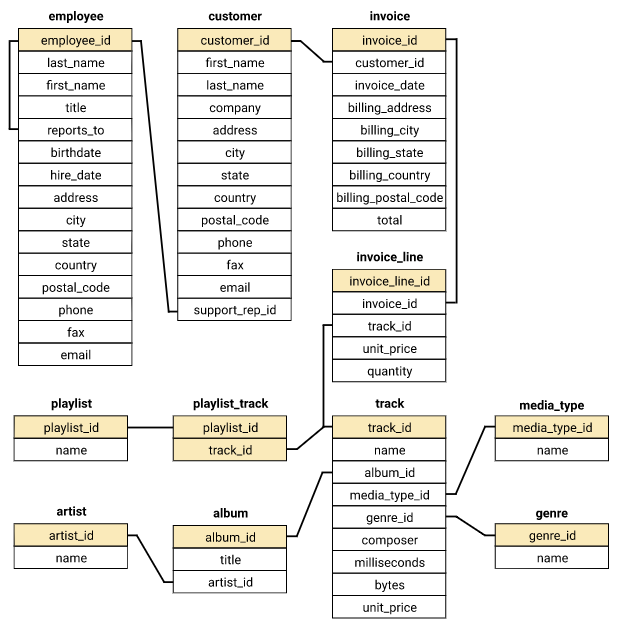

In [1]:
# Import image library
from IPython.display import Image

# Load image from local drive
Image(filename="4.2_SchemaDiagram.png", height=800, width=400)

In [2]:
# Connect to the database, "chinook."

%load_ext sql
%sql sqlite:///chinook.db

'Connected: @chinook.db'

In [3]:
%%sql
/* View date range of invoices. */

SELECT
    MIN(invoice_date) AS start_date,
    MAX(invoice_date) AS end_date
FROM invoice;

 * sqlite:///chinook.db
Done.


start_date,end_date
2017-01-03 00:00:00,2020-12-30 00:00:00


In [4]:
%%sql
/* View a list of the tables in the chinook database.  
    Sqlite_master: master listing of all database objects in the database */

SELECT 
    name, 
    type
FROM sqlite_master
WHERE type IN ("table", "view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## <font color='blue'> (1) Most popular music genres in the USA </font>

In [5]:
%%sql
/* View first 5 lines from table, invoice_line. */

SELECT * FROM invoice_line
LIMIT 5;

 * sqlite:///chinook.db
Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity
1,1,1158,0.99,1
2,1,1159,0.99,1
3,1,1160,0.99,1
4,1,1161,0.99,1
5,1,1162,0.99,1


In [6]:
%%sql
/* For USA, find the total number of tracks sold by genre.*/

SELECT g.name genre,  
            COUNT(t.track_id) AS tracks_sold, 
            c.country
        FROM track as t
        INNER JOIN genre g ON g.genre_id = t.genre_id
        LEFT JOIN invoice_line il ON il.track_id = t.track_id
        LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
        LEFT JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,tracks_sold,country
Rock,561,USA
Alternative & Punk,130,USA
Metal,124,USA
R&B/Soul,53,USA
Blues,36,USA
Alternative,35,USA
Pop,22,USA
Latin,22,USA
Hip Hop/Rap,20,USA
Jazz,14,USA


Top three most popular genres with the most tracks sold in the USA are Rock, Alternative & Punk, and Metal.

## <font color='blue'> (2) Sales Support Agents' performance </font>

In [7]:
%%sql
/* Create a table of each employee who is a Sales Support Agent and their total sales. */

WITH
    employee_sales AS
        (
        SELECT
            e.first_name || " " || e.last_name AS e_name,
            e.title AS e_title,
            CAST(SUM(i.total) AS INT) AS e_sales
        FROM employee AS e
        INNER JOIN customer AS c ON e.employee_id = c.support_rep_id
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        WHERE e.title = 'Sales Support Agent'
        GROUP BY e_name
        ORDER BY e_name
        ),
    total_sales AS
        (
        SELECT e_sales,
            SUM(CAST(e_sales AS FLOAT)) as t_sales
        FROM employee_sales
        )
                
SELECT 
    e_name AS employee_name,
    e_title AS title,
    "$" || e_sales AS sales,
    ROUND((CAST(e_sales AS FLOAT)) / (
             SELECT t_sales
            FROM total_sales) * 100, 1) || "%" AS sales_percent
    FROM employee_sales
    ;

 * sqlite:///chinook.db
Done.


employee_name,title,sales,sales_percent
Jane Peacock,Sales Support Agent,$1731,36.8%
Margaret Park,Sales Support Agent,$1584,33.6%
Steve Johnson,Sales Support Agent,$1393,29.6%


There are three Sales Support Agents at the Chinook record store, Jane Peacock, Margaret Park, and Steve Johnson.  The top performer is Jane Peacock who has $1,731 of sales or 36.8% of the total sales.  There is only a 6% difference between the top performer and the lowest performer, Steve Johnson, who has 29.6% of the total sales.  

## <font color='blue'> (3) Sales & Customers by country </font>
The next section will determine, for each country:  
>a. total number of customers  
>b. total sales  
>c. average sales per customer  
>d. average order amount

In [8]:
%%sql
/* View the number of unique countries in "customer" table. */

SELECT COUNT(DISTINCT country) FROM customer;

 * sqlite:///chinook.db
Done.


COUNT(DISTINCT country)
24


**(3a) Total number of customers by country**

To get a sense of the customer distribution by country, initially, the number of customers by country will be viewed.

In [9]:
%%sql
/* Subquery, country_customers, groups the number of customers by country. */
WITH
    country_customers AS
        (
        SELECT 
            country,
            COUNT(DISTINCT customer_id) AS customers
        FROM customer
        GROUP BY country
        )

/* Main query creates a table with country, number of customers, and percent of
    customers.  When sorted by number of customers, view the first 20 rows. */

SELECT country,
    customers,
    ROUND((CAST(customers AS FLOAT)) / (
        SELECT COUNT(*)
        FROM customer) * 100, 1) || "%" AS percent
FROM country_customers
ORDER BY customers DESC
LIMIT 20;

 * sqlite:///chinook.db
Done.


country,customers,percent
USA,13,22.0%
Canada,8,13.6%
Brazil,5,8.5%
France,5,8.5%
Germany,4,6.8%
United Kingdom,3,5.1%
Czech Republic,2,3.4%
India,2,3.4%
Portugal,2,3.4%
Argentina,1,1.7%


The USA has the most customers, 22% of them.  There are a number of countries that only have one customer. Those countries will be grouped as 'Other.'

**By country, compute: (3b) total sales, (3c) average sales per customer, (3d) and average order value.**

In [15]:
%%sql

    /*Subquery, country_or_other, renames all countries with only one customer with
        "other." */
WITH
    country_or_other AS  
        ( 
        SELECT 
        (CASE
            WHEN (                 
                SELECT COUNT(*)   
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Other"  
                ELSE c.country
            END) AS country, 
            c.*, i.*
        FROM customer c
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        ),  
    
    /* Subquery, country_sort, in a new column, sort, assigns a "1" if the country
        name is "Other," else assigns a "0."  Also, the subquery groups by country
        and counts the number of customers. */
    country_sort AS
        ( 
        SELECT country, 
            COUNT(DISTINCT customer_id) AS customers,
            (CASE
            WHEN country = 'Other' THEN 1
            ELSE 0
            END) AS sort,

            SUM(total) AS c_sales,
            COUNT(invoice_id) AS c_orders

        FROM country_or_other
        GROUP BY country
        ORDER BY sort 
        ),
    total_sales AS
        (
        SELECT
            c_sales,
            SUM(CAST(c_sales AS FLOAT)) AS t_sales
        FROM country_sort
        )

/* The main query, calls subquery, country_sort, and for each country, 
    computes the summary statistics:  sales percent, average sales per customer,
    and average sales per order.  */
SELECT 
    country,
    customers, 
    "$" || CAST(c_sales AS INT) AS total_sales,    
    ROUND(c_sales / (
        SELECT t_sales
        FROM total_sales) * 100, 1) || "%" AS sales_percent,    
    "$" || CAST((CAST(c_sales AS Float)/customers) AS INT) AS sales_per_customers,
    "$" || CAST((CAST(c_sales AS Float)/c_orders) AS INT) AS sales_per_orders
FROM country_sort
ORDER BY sort ASC, c_sales DESC;  --puts country, "Other," at the bottom

 * sqlite:///chinook.db
Done.


country,customers,sales,sales_percent,sales_per_customers,sales_per_orders
USA,13,$1040,22.1%,$80,$7
Canada,8,$535,11.4%,$66,$7
Brazil,5,$427,9.1%,$85,$7
France,5,$389,8.3%,$77,$7
Germany,4,$334,7.1%,$83,$8
Czech Republic,2,$273,5.8%,$136,$9
United Kingdom,3,$245,5.2%,$81,$8
Portugal,2,$185,3.9%,$92,$6
India,2,$183,3.9%,$91,$8
Other,15,$1094,23.2%,$72,$7


The top three countries by total sales are: USA, Canada, and Brazil.  The USA has the most customers, 13, and the most overall sales, 22% of total sales.  Interestingly, the Czech Republic, on average each customer has $136/customer; however, that is based on only 2 customers.  

## <font color='blue'> (4) Purchase popular individual tracks or Albums </font>

To increase revenue, management at Chinook record store wants to consider purchasing only the most popular tracks from each album rather than whole album purchases.  This next section will determine the percent of purchases that are whole albums versus individual tracks.  

Each track will have an album_id associated with it.  Albums may just have one, two, or a few tracks in it.  First, excluding albums with just a few tracks will be investigated.  

**Determine the number of album_ids that only have a few tracks.**

In [11]:
%%sql
/* Create a table that for albums that only have one, two, or three tracks,
    computes the following summary statistics: number of albums, 
    percent of total albums, and percent of total tracks. */

/* Subquery, "tracks_in_album," groups by album_id, counts the number of track_ids. */
WITH
    tracks_per_album AS
        (
        SELECT album_id, 
            COUNT(track_id) as track_count
        FROM track    
        GROUP BY album_id
        ),

    tracks_per_album_groups AS
        (
        SELECT track_count,
            CASE
                WHEN track_count = 1 THEN '1'
                WHEN track_count = 2 THEN '2'
                WHEN track_count = 3 THEN '3'
                WHEN track_count > 3 THEN '> 3'
            END AS n_tracks
        FROM tracks_per_album
        ORDER BY n_tracks
        ),

    summary_statistics AS
        (
        SELECT n_tracks,   
            COUNT(n_tracks) AS n_albums,
            (CAST(COUNT(n_tracks) AS Float) / (
                SELECT COUNT(*) FROM album))
                AS percent_albums,
            (CAST(SUM(track_count) AS Float) / (
                SELECT COUNT(*) FROM track))
                AS percent_tracks
        FROM tracks_per_album_groups
        GROUP BY n_tracks
        )        

/* Main query by number of tracks, counts number of album_ids. */
SELECT 
    n_tracks AS number_of_tracks_per_album,
    n_albums AS number_of_albums,
    ROUND(percent_albums * 100, 1) || "%" AS album_percent,
    ROUND(percent_tracks * 100, 1) || "%" AS tracks_percent
FROM summary_statistics
LIMIT 5;

 * sqlite:///chinook.db
Done.


number_of_tracks_per_album,number_of_albums,album_percent,tracks_percent
1,82,23.6%,2.3%
2,8,2.3%,0.5%
3,3,0.9%,0.3%
> 3,254,73.2%,96.9%


Number of albums with only 1, 2, or 3 tracks is 93, or 27% of total albums. More significantly, this makes up only 3.1% of the total tracks, so this project, will look at excluding albums with fewer than 3 tracks.  

**Invoices that purchased albums vs individual tracks computation**  
The number of tracks in an album will be compared to the number of tracks for an album in an invoice.  Initially, all the albums will be included in the analysis.  Then the analysis will be repeated but with removal of albums with fewer than three tracks.  

In [12]:
%%sql

WITH
    /* Subquery, tracks_per_album: for each uniqe album_id, counts the number of
        tracks. */
    tracks_per_album AS
    (
        SELECT DISTINCT album_id,
            COUNT(track_id) as track_count
        FROM track
        GROUP BY album_id
    ),

    /* Subquery, tracks_per_invoice: for each invoice_id, and for each unique
        album_id, counts number of tracks. Group by invoice_id AND album_id.*/
    tracks_per_invoice AS
    (
        SELECT il.invoice_id,
             t.album_id,
            COUNT(il.track_id) as track_count
        FROM invoice_line il
        
        INNER JOIN track t
        ON il.track_id = t.track_id
        
        GROUP BY invoice_id, album_id
    ),
    /* Subquery album_or_tracks: for each invoice, and for each album_id, compares
        the number of tracks in the album to the number of tracks in the invoice for
        a unique album_id. */
    album_or_tracks AS
        (
        SELECT il.invoice_id,
        CASE WHEN
            tpi.track_count = tpa.track_count THEN 'Album'
            ELSE 'Individual Tracks'
            END AS purchase_type
        FROM invoice_line il
        
        INNER JOIN tracks_per_invoice tpi
        ON il.invoice_id = tpi.invoice_id
        
        INNER JOIN tracks_per_album tpa
        ON tpi.album_id = tpa.album_id
        
        GROUP BY il.invoice_id
    )

/* Main query creates a table with the purchase type, album or individual tracks,
    the number of invoices, and the percent of invoices. */
SELECT 
    purchase_type,
    COUNT(DISTINCT il.invoice_id) AS invoice_count,
    ROUND(CAST(COUNT(DISTINCT il.invoice_id) AS FLOAT) / (
        SELECT COUNT(*)
        FROM invoice) * 100, 1) || "%" AS invoice_percent   
FROM album_or_tracks AS aot
    
/* Join pt table with invoice_line table */
INNER JOIN invoice_line il
    ON il.invoice_id = aot.invoice_id
GROUP BY purchase_type;

 * sqlite:///chinook.db
Done.


purchase_type,invoice_count,invoice_percent
Album,117,19.1%
Individual Tracks,497,80.9%


In considering all the invoices, 117 invoices or 19.1% of the invoices included a purchase of an album.  And 497 invoices or 80.9% of the invoices included purchase of individual tracks.  Based on these results, it is recommended to company management to continue purchasing full albums, otherwise, there is a risk of possibly losing 19% revenue.  

**Album vs Individual Tracks - repeat previous calculation, but remove albums that have fewer than three tracks.**

In [13]:
%%sql

WITH
    /* Subquery, tracks_per_album: for each uniqe album_id, counts the number of
        tracks. */
    tracks_per_album AS
    (
        SELECT DISTINCT album_id,
            CASE
                WHEN COUNT(track_id) > 2 THEN COUNT(track_id)
                ELSE 0
                END AS track_count
        FROM track
        GROUP BY album_id
    ),

    /* Subquery album_or_tracks: for each invoice, and for each album_id, compares
        the number of tracks in the album to the number of tracks in the invoice for
        a unique album_id. */
    tracks_per_invoice AS
    (
        SELECT il.invoice_id,
             t.album_id,
            COUNT(il.track_id) as track_count
        FROM invoice_line il
        
        INNER JOIN track t
        ON il.track_id = t.track_id
        
        GROUP BY invoice_id, album_id
    ),
    /* Subquery  */
    album_or_tracks AS
        (
        SELECT il.invoice_id,
        CASE WHEN
            tpi.track_count = tpa.track_count THEN 'Album'
            ELSE 'Individual Tracks'
            END AS purchase_type
        FROM invoice_line il
        
        INNER JOIN tracks_per_invoice tpi
        ON il.invoice_id = tpi.invoice_id
        
        INNER JOIN tracks_per_album tpa
        ON tpi.album_id = tpa.album_id
        
        GROUP BY il.invoice_id
    )

/* Main query creates a table with the purchase type, album or individual tracks,
    the number of invoices, and the percent of invoices. */
SELECT 
    purchase_type,
    COUNT(DISTINCT il.invoice_id) AS invoice_count,
    ROUND(CAST(COUNT(DISTINCT il.invoice_id) AS FLOAT) / (
        SELECT COUNT(*)
        FROM invoice) * 100, 1) || "%" AS invoice_percent   
FROM album_or_tracks AS aot

INNER JOIN invoice_line il 
ON il.invoice_id = aot.invoice_id

GROUP BY purchase_type;

 * sqlite:///chinook.db
Done.


purchase_type,invoice_count,invoice_percent
Album,111,18.1%
Individual Tracks,503,81.9%


Removing albums with fewer than three tracks from the computations resulted in only 1% difference in invoice percentage.  For this analysis, this is not significant, and the prior recommendation to company management still holds i.e. to continue purchasing whole albums, otherwise, risk losing significant revenue.   

**<font color='blue'>  CONCLUSION  </font>**  

The goal of this project was to complete various data analysis to assist the Chinook record store managment make business decisions.  There were four sections to this project:
1. The most popular genres in the USA were found to be Rock, Alternative & Punk, and Metal.
2. The performance of each Sales Support Agents were tabulated.  Of the three Sales Support Agents, the top performer has been Jane Peacock with about 37% of the total sales.  Although, there was only 6% difference between the first and third performers.
3. Based on country, the number of customers and total sales were evaluated.  The USA has the most customers, 13, and the most total sales, $1,040, or 22% of the total sales.  Next is Canada with 8 customers, and 11.% of the total sales.  And third is Brazil with 5 customers and 9% of total sales.  
4. The invoices were analyzed based on purchases of either albums or individual tracks.  Albums were purchased in 19% of the invoices, so it is recommended for management to continue with their purchasing practices i.e. purchasing whole albums.